In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## This notebook builds on ARIMA notebook thereofre i will not be re repeating here data explorations and visualization.

# Time series LSTM

In [2]:
# Load data
import pandas as pd
from pathlib import Path

path = Path('/content/gdrive/My Drive/Colab Notebooks')
parser = lambda x: pd.to_datetime(x, format='%Y-%m')
df = pd.read_csv(path/'data.csv', names=['date', 'value'], header=0, parse_dates=['date'], date_parser=parser, index_col=['date'])
ts = df['value']
print(f'Head of the time series:\n{ts.head()}\nTail fo the time series:\n{ts.tail()}')

Head of the time series:
date
1749-01-01    58.0
1749-02-01    62.6
1749-03-01    70.0
1749-04-01    55.7
1749-05-01    85.0
Name: value, dtype: float64
Tail fo the time series:
date
1808-05-01    13.5
1808-06-01    13.5
1808-07-01     6.7
1808-08-01     8.0
1808-09-01    11.7
Name: value, dtype: float64


In [3]:
print(f'Data types are:\n{ts.dtypes}')

Data types are:
float64


In [4]:
print(f'Number of missing values is\n{df.isnull().sum()}')

Number of missing values is
value    0
dtype: int64


In [5]:
# train test split. 502 months as training and 215 months as test
train = ts[:502]
test = ts[502:]

train_ls = train.tolist()
test_ls = test.tolist()

print(f"Training set has {len(train_ls)} observations.")
print(f"Test set has {len(test_ls)} observations.")

Training set has 502 observations.
Test set has 215 observations.


In [6]:
# prepare data for LSTM network
import numpy as np

def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-SEQUENCE_SIZE-1):
        window = obs[i:(i+SEQUENCE_SIZE)]
        after_window = obs[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x), np.array(y)
    
    
SEQUENCE_SIZE = 10
x_train,y_train = to_sequences(SEQUENCE_SIZE,train_ls)
x_test,y_test = to_sequences(SEQUENCE_SIZE,test_ls)

print(f"Shape of training set: {x_train.shape}")
print(f"Shape of test set: {x_test.shape}")

Shape of training set: (491, 10, 1)
Shape of test set: (204, 10, 1)


In [7]:
# Building and trainig LSTM model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.callbacks import EarlyStopping

print('Build model...')
model = Sequential()
model.add(LSTM(64, dropout=0.0, recurrent_dropout=0.0,input_shape=(None, 1)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
print('Train...')

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Using TensorFlow backend.


Build model...
Instructions for updating:
Colocations handled automatically by placer.
Train...
Instructions for updating:
Use tf.cast instead.
Train on 491 samples, validate on 204 samples
Epoch 1/1000
 - 2s - loss: 5204.0477 - val_loss: 1039.0131
Epoch 2/1000
 - 0s - loss: 4798.4151 - val_loss: 799.4453
Epoch 3/1000
 - 0s - loss: 4196.8212 - val_loss: 504.6089
Epoch 4/1000
 - 0s - loss: 3304.6742 - val_loss: 273.4652
Epoch 5/1000
 - 0s - loss: 2174.4813 - val_loss: 181.5588
Epoch 6/1000
 - 0s - loss: 1461.4372 - val_loss: 104.3838
Epoch 7/1000
 - 0s - loss: 1042.9509 - val_loss: 98.8088
Epoch 8/1000
 - 0s - loss: 783.0088 - val_loss: 83.0552
Epoch 9/1000
 - 0s - loss: 624.9844 - val_loss: 87.8306
Epoch 10/1000
 - 0s - loss: 519.5891 - val_loss: 82.2155
Epoch 11/1000
 - 0s - loss: 456.7203 - val_loss: 83.9392
Epoch 12/1000
 - 0s - loss: 406.9768 - val_loss: 121.1339
Epoch 13/1000
 - 0s - loss: 388.4389 - val_loss: 79.1368
Epoch 14/1000
 - 0s - loss: 376.7780 - val_loss: 93.2329
Epoch 

In [8]:
# calculate model error - RMSE
from sklearn import metrics

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print(f'Score (RMSE): {score}')

Score (RMSE): 9.133845506498332


Text(0.5, 1.0, 'RMSE: 9.133845506498332')

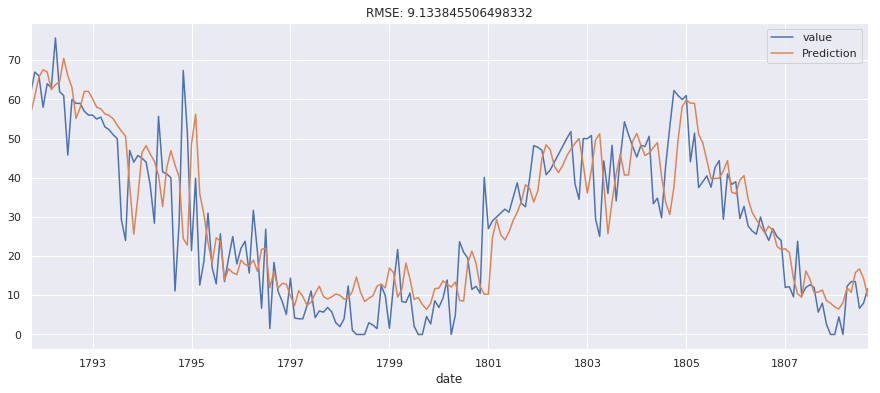

In [9]:
# Visualize predictions on unseen test data
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import seaborn; seaborn.set()

test_plot = test[11:]

pred = pd.DataFrame(pred, index= test_plot.index, columns=['Prediction'])
pd.concat([test_plot, pred], axis=1).plot()
plt.title(f'RMSE: {score}')

## Overall LSTM nework gave better predictions for this data set than ARIMA model. Trained LSTM nework gave quite accurate prediction for ~18 yeas forward, based on ~40 years worth of past data.

## Next steps / Improvements:
* normalize input data for the network
* further finetune LSTM model hyperparameters
* investigate shift in predicted data versus test data
* there may be more factors influencing the values other than just past values